# Projeto Final - Ciência dos dados
### Alunos:
- Beatriz Lourenço 
- Fernando Kenji 
- Sophia Kerber
- Pedro H. Menezes

### Pergunta Motivadora:
___
É possível prever a avaliação de um livro (no ranking do Goodreads) com as seguintes variáveis?
- Inicial do autor
- Número de páginas
- Gênero
- Formato do livro (Capa dura, capa em papel, versão Kindle...)


### Por que regressão linear?
___

Como o objetivo do projeto era prever a avaliação do livro, decidiu-se utilizar a regressão linear para tanto, uma vez que a variável de saída é quantitativa. A ideia da regressão linear é aproximar os dados de uma reta, tentando diminuir o erro quadrático ao máximo. Utilizamos o One Hot Enconder, aliado ao SciKitLearn para dividir o dataset, classificar as variáveis qualitativas em números binários, e finalmente fazer a predição e o teste do dataset.

As técnicas que se prestam a este tipo de análise: regressão linear, *regression tree*, *random forest regression* - EXPLICAR OS OUTROS 2

### Como melhorar a análise?
___

Pode-se melhorar a análise feita por meio da K-Folds Cross Validation.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn
import statsmodels.api as sm

In [47]:
csv = pd.read_csv('book_data.csv')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


## Análise Exploratória

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


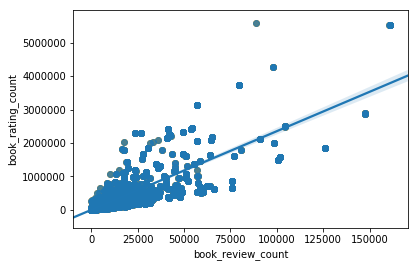

In [48]:
plt.scatter(csv.book_review_count, csv.book_rating_count, color='orange')
seaborn.regplot(x=csv.book_review_count,y=csv.book_rating_count)

A partir do gráfico acima é possível perceber uma correlação entre as variáveis do número de avaliações com a classificação do livro no ranking do Goodreads. Portanto, essa é uma variável interessante de ser explorada

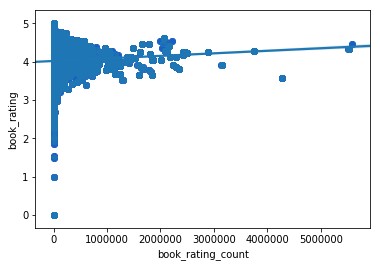

In [49]:
plt.scatter(csv.book_rating_count, csv.book_rating, color='b')
seaborn.regplot(x=csv.book_rating_count,y=csv.book_rating)

Não há visivelmente uma correlação entre a contagem da avaliação do livro e sua própria avaliação, logo elas não estão muito bem correlacionadas e possivelmente usar ela na regressão.

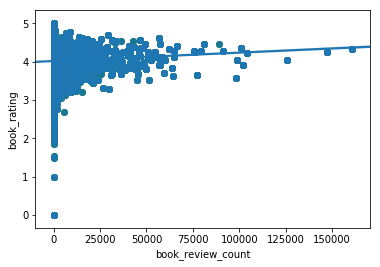

In [50]:
plt.scatter(csv.book_review_count, csv.book_rating, color='green')
seaborn.regplot(x=csv.book_review_count,y=csv.book_rating)

Da mesma forma que a anterior as duas variáveis aqui não estão evidentemente correlacionadas e não serão utilizadas para o modelo.

In [51]:
# Retirando todas as variáveis que não serão utilizadas por enquanto
csv.drop(['book_isbn','book_desc','book_edition','book_rating_count','image_url'],axis=1,inplace=True)
# Retirando os livros com informações faltando
csv=csv.dropna()
csv.head()

,book_authors,book_format,book_pages,book_rating,book_review_count,book_title,genres
0,Suzanne Collins,Hardcover,374 pages,4.33,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...
1,J.K. Rowling|Mary GrandPré,Paperback,870 pages,4.48,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction
2,Harper Lee,Paperback,324 pages,4.27,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Paperback,279 pages,4.25,54322,Pride and Prejudice,Classics|Fiction|Romance
4,Stephenie Meyer,Paperback,498 pages,3.58,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...


In [53]:
def limpando(csv):
    # Ajeitando as variáveis
    ar = csv['genres'].tolist()
    ar1 = []
    iniciais = []
    paginas = []

    # Escolhendo como gênero literário apenas o primeiro listado.
    for i in ar:
        if i == "":
            ar1.append("")
        else:
            a = i.split('|')
            ar1.append(a[0])

    # Selecionando apenas a inicial dos nomes dos autores
    for i in csv['book_authors']:
        iniciais.append(i[0])

    # Apenas o número de páginas aparecerá, sem a palavra "pages"
    for i in csv['book_pages']:
        numero = i.split(' ')
        paginas.append(int(numero[0]))
    return ar1,paginas,iniciais
ar1,paginas,iniciais = limpando(csv)
print(ar1[0:10],paginas[0:10],iniciais[0:10])

['Young Adult', 'Fantasy', 'Classics', 'Classics', 'Young Adult', 'Historical', 'Fantasy', 'Classics', 'Classics', 'Fantasy'] [374, 870, 324, 279, 498, 552, 767, 122, 1037, 1728] ['S', 'J', 'H', 'J', 'S', 'M', 'C', 'G', 'M', 'J']


In [13]:
len(csv.index)

48260

In [14]:
# Criando colunas no DataFrame para as iniciais dos autores, os números de páginas e o principal gênero do livro
ar1=pd.DataFrame({'genero':ar1},index = csv.index)
iniciais_ = pd.DataFrame({'iniciais':iniciais}, index = csv.index)
paginas_ = pd.DataFrame({'paginas':paginas}, index = csv.index)

In [15]:
csv = csv.join(ar1,how='inner')
csv = csv.join(iniciais_,how='inner')
csv = csv.join(paginas_,how='inner')

In [16]:
csv.head()

,book_authors,book_format,book_pages,book_rating,book_review_count,book_title,genres,genero,iniciais,paginas
0,Suzanne Collins,Hardcover,374 pages,4.33,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,Young Adult,S,374
1,J.K. Rowling|Mary GrandPré,Paperback,870 pages,4.48,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,Fantasy,J,870
2,Harper Lee,Paperback,324 pages,4.27,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,Classics,H,324
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Paperback,279 pages,4.25,54322,Pride and Prejudice,Classics|Fiction|Romance,Classics,J,279
4,Stephenie Meyer,Paperback,498 pages,3.58,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,Young Adult,S,498


In [17]:
csv['genero'].value_counts()[40:70]

Politics             137
Dark                 130
Asian Literature     125
Music                122
Sports and Games     121
Realistic Fiction    121
Travel               120
Adventure            113
Contemporary         109
Literature           100
Economics             89
Lgbt                  87
Crime                 87
Food and Drink        81
Holiday               69
Westerns              65
War                   65
Language              59
Feminism              57
Glbt                  54
Urban                 51
Parenting             49
Health                49
Amish                 43
Education             37
Culture               36
Reference             32
Sports                32
Sociology             31
Writing               30
Name: genero, dtype: int64

In [18]:
print('Gêneros mais famosos:')
fantasy = csv.loc[(csv['genero']=='Fantasy')]
print('Média da Fantasia: ' + str(fantasy['book_rating'].mean()))
classics = csv.loc[(csv['genero']=='Classics')]
print('Média do clássico: ' + str(classics['book_rating'].mean()))
fiction = csv.loc[(csv['genero']=='Fiction')]
print('Média da ficção: ' + str(fiction['book_rating'].mean()))
print('-----------------')
print('Gêneros pouco famosos:')
economics = csv.loc[(csv['genero']=='Economics')]
print('Média da economics: ' + str(economics['book_rating'].mean()))
war = csv.loc[(csv['genero']=='War')]
print('Média do gênero Guerra: ' + str(war['book_rating'].mean()))
sports = csv.loc[(csv['genero']=='Sports')]
print('Média do gênero Esportes: ' + str(sports['book_rating'].mean()))


Gêneros mais famosos:
Média da Fantasia: 4.054462729912877
Média do clássico: 3.9510420944558335
Média da ficção: 3.8847085749160746
-----------------
Gêneros pouco famosos:
Média da economics: 4.087415730337078
Média do gênero Guerra: 4.130461538461538
Média do gênero Esportes: 4.022812500000001


A partir da análise acima é possível observar que, na média, os gêneros não alteram muito a avaliação do livro. Porém, como o campo amostral ficou pequeno, seria interessante pensar em outra maneira de ver a correlação entre gênero e avaliação do livro

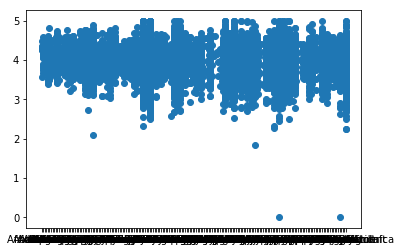

In [19]:
plt.scatter(csv['genero'].sort_values(), csv.book_rating)
#seaborn.regplot(x=csv['genero'].sort_values(),y=csv.book_rating)

No gráfico acima, apesar de não se saber bem quais são cada um dos gêneros, pode enxergar que não há uma forte relação entre o gênero e sua avaliação, podendo ser deixado de lado na construção da regressão linear.

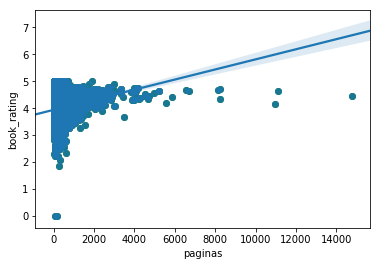

In [20]:
plt.scatter(csv.paginas, csv.book_rating, color='green')
seaborn.regplot(x=csv.paginas,y=csv.book_rating)

Com o gráfico acima é possível perceber que há uma certa correlação com a avaliação e o número de páginas. Como o gráfico acima está com valores que não permitem analisar o local onde há mais pontos, vamos focar em uma região específica (até 1000 páginas).

In [21]:
pag = csv.loc[(csv.paginas < 1000)]
pag.book_rating.head()

0    4.33
1    4.48
2    4.27
3    4.25
4    3.58
Name: book_rating, dtype: float64

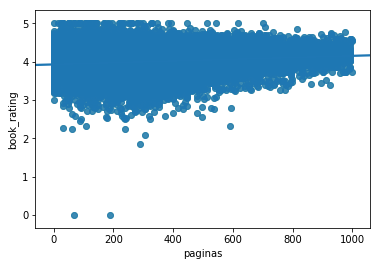

In [22]:
plt.scatter(pag.paginas, pag.book_rating, color='green',alpha = 0.3)
seaborn.regplot(x=pag.paginas,y=pag.book_rating, fit_reg=True)

A partir do gráfico acima é possível perceber que a correlação entre essas variáveis não é tão grande. Portanto, elas podem ser deixadas de serem levadas em conta na hora da regressão neste primeiro momento.

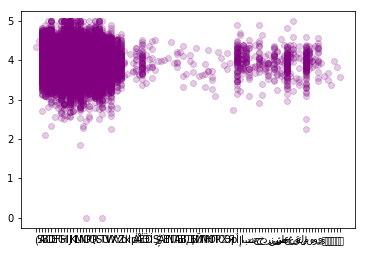

In [23]:
plt.scatter(csv['iniciais'].sort_values(), csv.book_rating, color='purple',alpha=0.2)
#seaborn.regplot(x=csv['iniciais'].sort_values(),y=csv.book_rating)

Com o gráfico acima fica complicado de ver as iniciais dos autores pela quantidade que existe, não podendo ser percebido nenhum padrão. Para melhorar a visualização, faremos uma secção do gráfico.

In [24]:
ini = csv[['iniciais','book_rating']]
inia= ini.sort_values(by='iniciais')[0:47000]

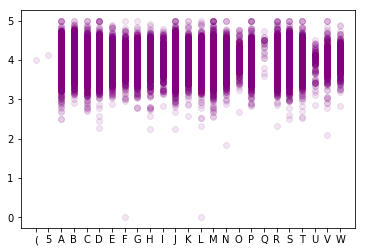

In [25]:
plt.scatter(inia.iniciais, inia.book_rating, color='purple',alpha = 0.1)

Com o gráfico acima é possível perceber que algumas letras ficam mais na média dos valores (4) e algumas conseguem se deslocar mais para regiões da parte de cima quanto da parte de baixo. Logo, a variável inicial do nome do autor pode ser interessante de ser analisada na regressão.

## Limpeza dos dados e regressão

In [27]:
# Retirando as colunas irrelevantes para a análise geral de avaliações
csv.drop(['book_authors','genres','book_pages'],axis=1,inplace=True)

In [28]:
csv.head()

,book_format,book_rating,book_review_count,book_title,genero,iniciais,paginas
0,Hardcover,4.33,160706,The Hunger Games,Young Adult,S,374
1,Paperback,4.48,33264,Harry Potter and the Order of the Phoenix,Fantasy,J,870
2,Paperback,4.27,79450,To Kill a Mockingbird,Classics,H,324
3,Paperback,4.25,54322,Pride and Prejudice,Classics,J,279
4,Paperback,3.58,97991,Twilight,Young Adult,S,498


In [29]:
csv.shape

(48260, 7)

In [30]:
# Apenas os livros com 3.5 estrelas ou mais de avaliação no Goodreads
csv.loc[(csv['book_rating'] >= 3.5)]

,book_format,book_rating,book_review_count,book_title,genero,iniciais,paginas
0,Hardcover,4.33,160706,The Hunger Games,Young Adult,S,374
1,Paperback,4.48,33264,Harry Potter and the Order of the Phoenix,Fantasy,J,870
2,Paperback,4.27,79450,To Kill a Mockingbird,Classics,H,324
3,Paperback,4.25,54322,Pride and Prejudice,Classics,J,279
4,Paperback,3.58,97991,Twilight,Young Adult,S,498
5,Hardcover,4.36,100821,The Book Thief,Historical,M,552
6,Paperback,4.25,9439,The Chronicles of Narnia,Fantasy,C,767
7,Paperback,3.90,42156,Animal Farm,Classics,G,122
8,Paperback,4.29,17452,Gone with the Wind,Classics,M,1037
9,Mass Market Paperback,4.59,1652,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Fantasy,J,1728


In [31]:
# Separando as variáveis em quantitativas, qualitativas e a desejada
y = csv['book_rating'].values
num = csv[['paginas','book_review_count']]
qual = csv[['book_format','genero','iniciais']]

In [32]:
qual.head()

,book_format,genero,iniciais
0,Hardcover,Young Adult,S
1,Paperback,Fantasy,J
2,Paperback,Classics,H
3,Paperback,Classics,J
4,Paperback,Young Adult,S


In [33]:
encoder = OneHotEncoder()
capa_encoded = encoder.fit_transform(qual)

In [34]:
x_num = num.values

In [35]:
#Transformar em array facilita a exploração dos dados
x_encoded = capa_encoded.toarray()

In [36]:
#Juntando a lista binária e as páginas
X = np.concatenate((x_num,x_encoded), axis=1)

In [37]:
X[0]

array([3.74000e+02, 1.60706e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [38]:
#Rating do livro 1
y[0]

4.33

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing,utils, metrics
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i]>5:
        y_pred[i]=5
    elif y_pred[i]<0:
        y_pred[i]=0
        
df = pd.DataFrame({'Atual': y_test.flatten(), 'Predito': y_pred.flatten()})
df.head()

,Atual,Predito
0,3.86,3.863638
1,4.36,4.087816
2,4.52,4.179647
3,4.25,3.980965
4,3.57,3.836996


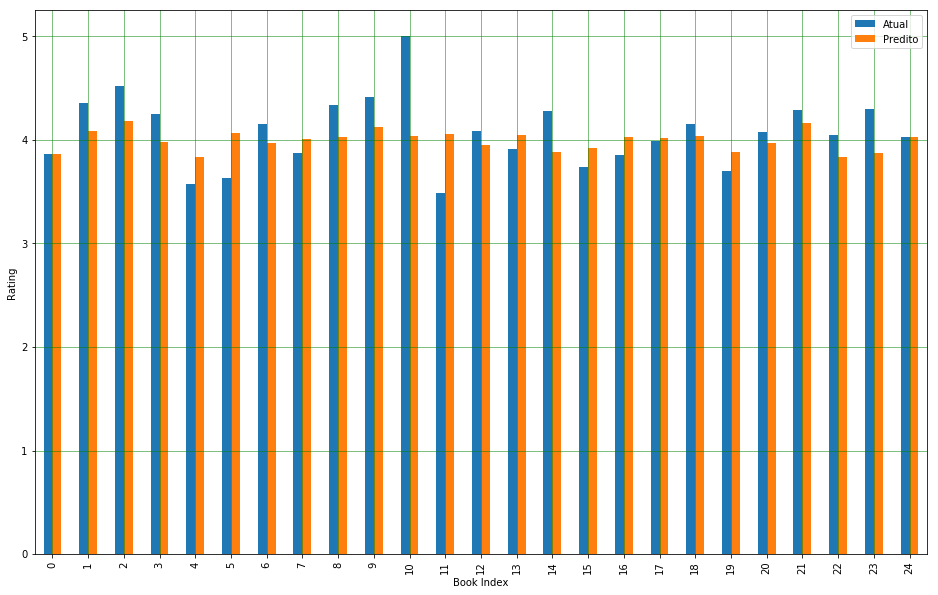

In [40]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Book Index')
plt.ylabel('Rating')
plt.show()

In [41]:
print("O R² é " + str(metrics.r2_score(df['Atual'],df['Predito'])))

O R² é -0.18662428233709738


In [47]:
X2 = sm.add_constant(y_test)
est = sm.OLS(y_pred,X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     461.8
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          4.24e-100
Time:                        14:05:04   Log-Likelihood:                 1811.2
No. Observations:                9652   AIC:                            -3618.
Df Residuals:                    9650   BIC:                            -3604.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4029      0.028    122.617      0.0

In [45]:
#Usando outro DataFrame (de 2018) para fazer a predição:
teste_X2 = pd.read_csv('book_data_2018.csv')

In [ ]:
teste_X2.drop(['book_desc', 'book_edition', 'book_isbn', 'book_rating_count', 'book_review_count', 'image_url'], axis=1, inplace=True)
teste_X2=teste_X2.dropna()
teste_X2.head()

In [ ]:
ar_2018 = teste_X2['genres'].value_counts()
ar1_2018 = []
iniciais_2018 = []
paginas_2018 = []

# Escolhendo como gênero literário apenas o primeiro listado.
for i in ar_2018.index:
    if i == "":
        ar1_2018.append("")
    else:
        a = i.split('|')
        ar1_2018.append(a[0])
        
# Selecionando apenas a inicial dos nomes dos autores
for i in teste_X2['book_authors']:
    iniciais_2018.append(i[0])

# Apenas o número de páginas aparecerá, sem a palavra "pages"
for i in teste_X2['book_pages']:
    numero_2018 = i.split(' ')
    paginas_2018.append(int(numero_2018[0]))
print(paginas_2018[0:10])
print(iniciais_2018[0:10])
print(ar1_2018[0:10])

In [ ]:
# Criando colunas no DataFrame para as iniciais dos autores, os números de páginas e o principal gênero do livro
ar1_2018=pd.DataFrame({'genero':ar1_2018})
iniciais_2018_ = pd.DataFrame({'iniciais':iniciais_2018})
paginas_2018_ = pd.DataFrame({'paginas':paginas_2018})

In [ ]:
teste_X2 = teste_X2.join(ar1_2018,how='inner')
teste_X2 = teste_X2.join(iniciais_2018_,how='inner')
teste_X2 = teste_X2.join(paginas_2018_,how='inner')
teste_X2.head()

In [ ]:
teste_X2.drop(['book_authors', 'book_pages', 'genres'], axis=1, inplace=True)
teste_X2.head()

In [ ]:
y_pred2 = regressor.predict(teste_X2)

for i in range(len(y_pred2)):
    if y_pred2[i]>5:
        y_pred2[i]=5
    elif y_pred2[i]<0:
        y_pred2[i]=0
        
df2 = pd.DataFrame({'Atual': y_test2.flatten(), 'Predito': y_pred2.flatten()})
df2.head()